# Diversity Analysis
In this notebook we will explore some diversity aspect of the generated ligands. This includes
1. Murcko scaffold analysis
2. Tanimoto similarity

In [1]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.core.display import HTML
from rdkit.Chem import AllChem, Draw, PandasTools, rdFingerprintGenerator, MolFromInchi

from src.evaluation.utils import (draw_colored_scaffold_ligands,
                              max_tanimoto_similarity,
                              mean_tanimoto_similarity, read_mols,
                              tanimoto_similarity_matrix)

PandasTools.RenderImagesInAllDataFrames(images=True)

## Load and prepare ligands
Load generated ligands and remove ligands with a binding affinity > 1,000 nm

In [2]:
# read data
data = read_mols('../results_5n1f_25_02/5n1f/results.sdf', remove_dupliactes=False)

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,GA_smiles,AP_smiles_dummy,FP_smiles_dummy,GA_smiles_dummy,AP,FP,GA
0,,0.825466,133.57,2,"InChI=1S/C24H29N5/c1-23(2,3)19-6-4-17(5-7-19)1...",N#Cc1c[nH]c2ncccc12,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,None,[4*]c1ccnc2[nH]cc(C#N)c12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,None,136,8,NaN
1,,0.853035,300.13,3,InChI=1S/C24H27N5O2/c1-16-23-21(27-26-16)7-4-8...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,COCc1ccccc1,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[18*]c1cccc(COC)c1,297,51,114.0
2,,1.037959,3151.95,3,"InChI=1S/C26H23ClN4O4S/c1-15-13-17(36(3,32)33)...",Nc1nccc2c(Cl)coc12,Cc1cc(S(C)(=O)=O)ccc1-c1nccn1C,OCc1ccccc1,[21*]c1cnc(N)c2oc([36*])c(Cl)c12,[28*]c1nc(-c2ccc(S(C)(=O)=O)cc2C)n(C)c1[39*],[10*]c1ccc(CO[24*])cc1,400,335,98.0
3,,1.509653,1481.09,3,InChI=1S/C22H21Cl2N5O/c1-13-21-19(27-26-13)3-2...,Cc1n[nH]c2cccc(O)c12,c1cnn(C2CC[NH2+]CC2)c1,Clc1ccccc1Cl,[31*]c1cc(O[37*])c2c(C)n[nH]c2c1,[7*]c1cn(C2CC[NH2+]CC2)nc1[26*],[3*]c1ccc(Cl)c(Cl)c1,297,51,86.0
4,,1.553260,7036.25,3,InChI=1S/C31H36FN3OS/c1-5-21-16-26(36)25(32)17...,c1cc2ccsc2cn1,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,CCc1ccc(F)c(O)c1,[15*]c1c([24*])sc2cnccc12,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,[31*]c1cc(F)c(O)cc1CC,49,8,85.0

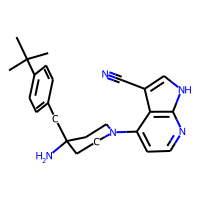
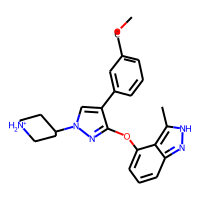
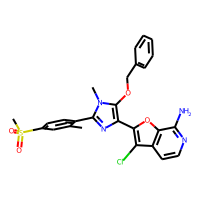
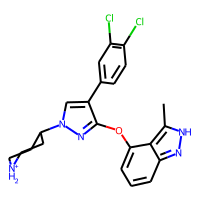
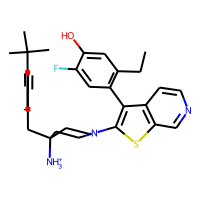

In [3]:
# remove ligands with unfavourable binding affinity
data = data[data['binding_affinity'] <= 1000].copy().reset_index(drop=True)
HTML(data.head().to_html(notebook=True))

Some molecules are duplicates since their fragments might only differ in the dummy atoms. Since the resulting molecules are similar, we remove duplicates.

In [4]:
print(f"Duplicates: {sum(data['inchi'].duplicated())}")
data = data.drop_duplicates(subset='inchi').reset_index(drop=True)

Duplicates: 30


## 1. Murcko Similarity
A Murcko scaffold can be used to represent the core structure of a ligand. It is the union of all rings and linkers - between rings -  of a molecule, thus disregarding the side chains. Here, we will use these Murcko scaffolds to analyse the diversity of the generated ligands from a structural point of view. First, we will look at the quantities of the scaffolds (1.1). Next, we determine the most frequent scaffolds (1.2). Lastly, we *measure* the information-based entropy of the scaffold using the Shannon-Entropy (1.3).

In [5]:
# add murcko smiles to dataframe
PandasTools.AddMurckoToFrame(data)

In [6]:
# determine distinct scaffold
scaffolds = data.groupby('Murcko_SMILES').size()
scaffolds = scaffolds.sort_values(ascending=False)

In [7]:
# assigned each distinct scaffold to an ID
data['scaffold_id'] = data.apply(lambda x: scaffolds.index.get_loc(x.Murcko_SMILES), axis=1)

### 1.1 Scaffold Quantities
Let's take a look at the quantities and frequencies of the scaffolds, and inspect the most frequent scaffolds.

In [8]:
print(f"Number of unique scaffolds: {scaffolds.size}")
print(f"Number of singletons: {sum(scaffolds == 1)}")

Number of unique scaffolds: 800
Number of singletons: 611


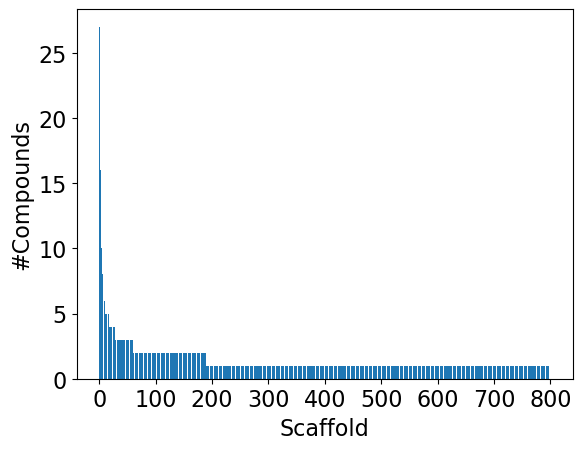

In [9]:
# plot top 15 scaffolds 
plt.bar(range(len(scaffolds)), scaffolds)
plt.ylabel('#Compounds', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### 1.2 Scaffold Frequencies 

In [10]:
print(f"The most frequent scaffold is represented by {scaffolds[0]} compounds ({scaffolds[0]/data.index.size * 100}%)")

The most frequent scaffold is represented by 27 compounds (2.3156089193825045%)


The 20 most frequent scaffolds:

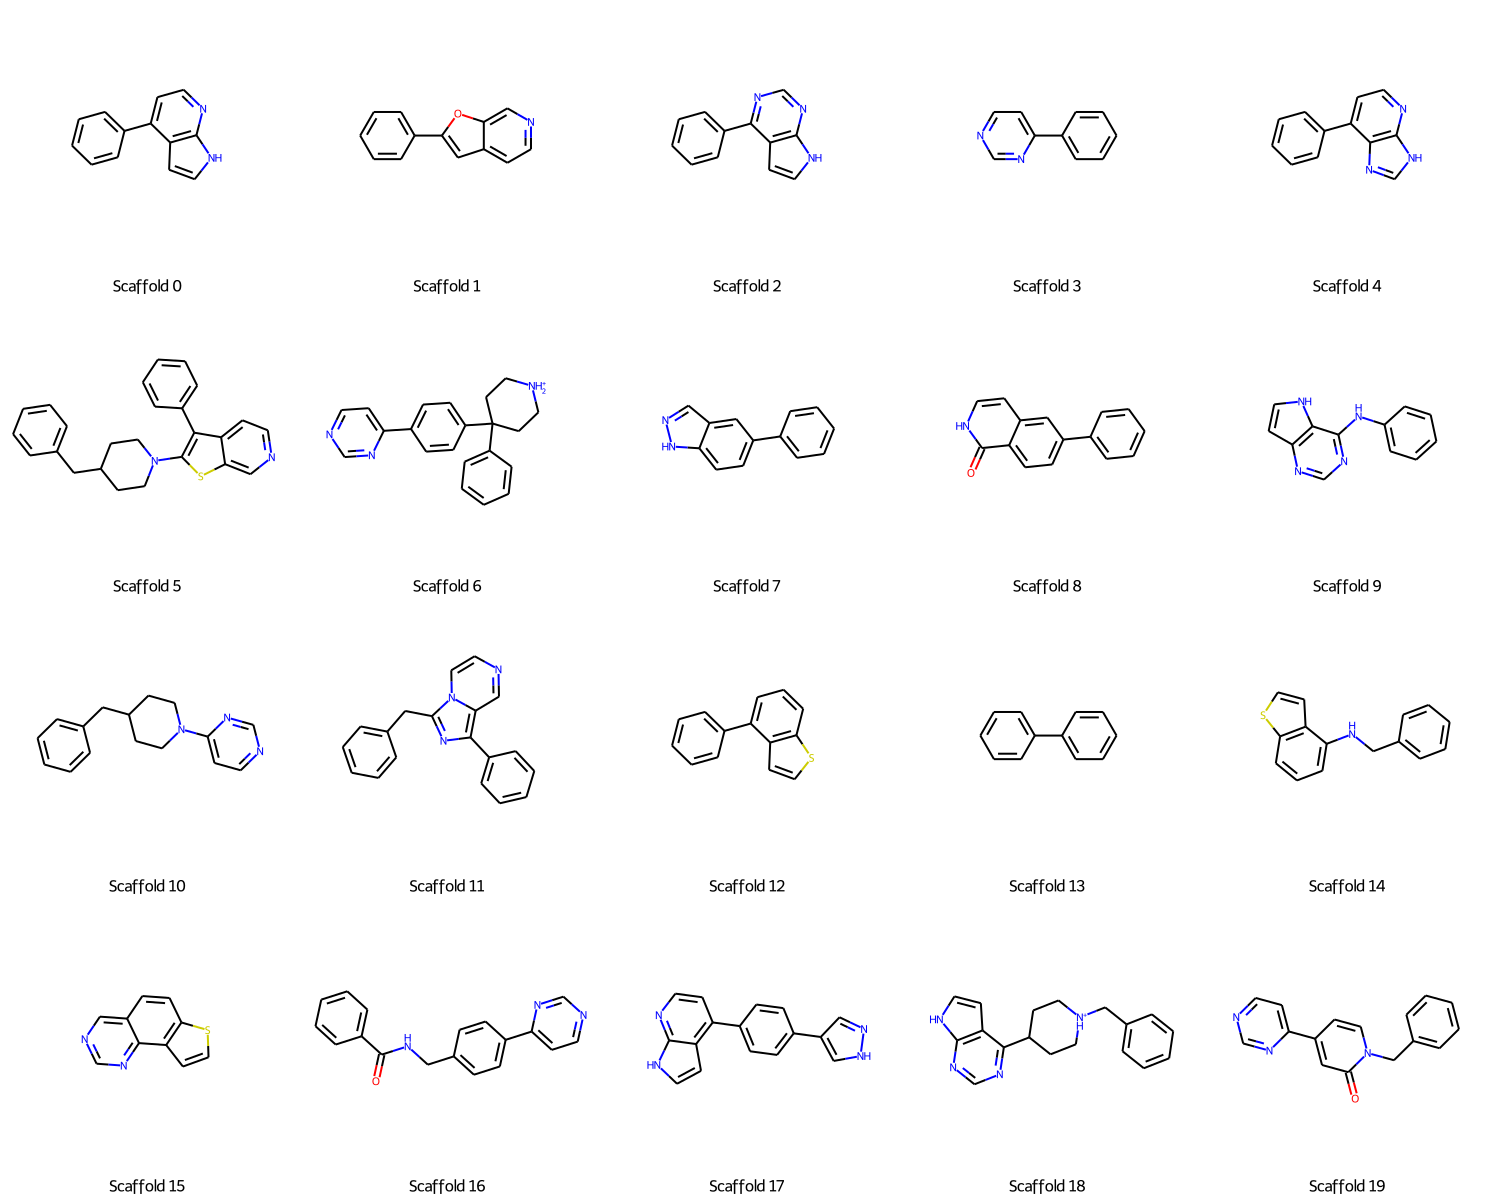

In [11]:
# print most common scaffolds
mols = [AllChem.MolFromSmiles(idx) for idx in scaffolds.index[:20]]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols, 
    legends=[
        f"Scaffold {i}" for i in range(20)
    ],  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)
img

Ligands that represent the 5 most frequent scaffold (5 ligands per scaffold) with colored scaffolds:

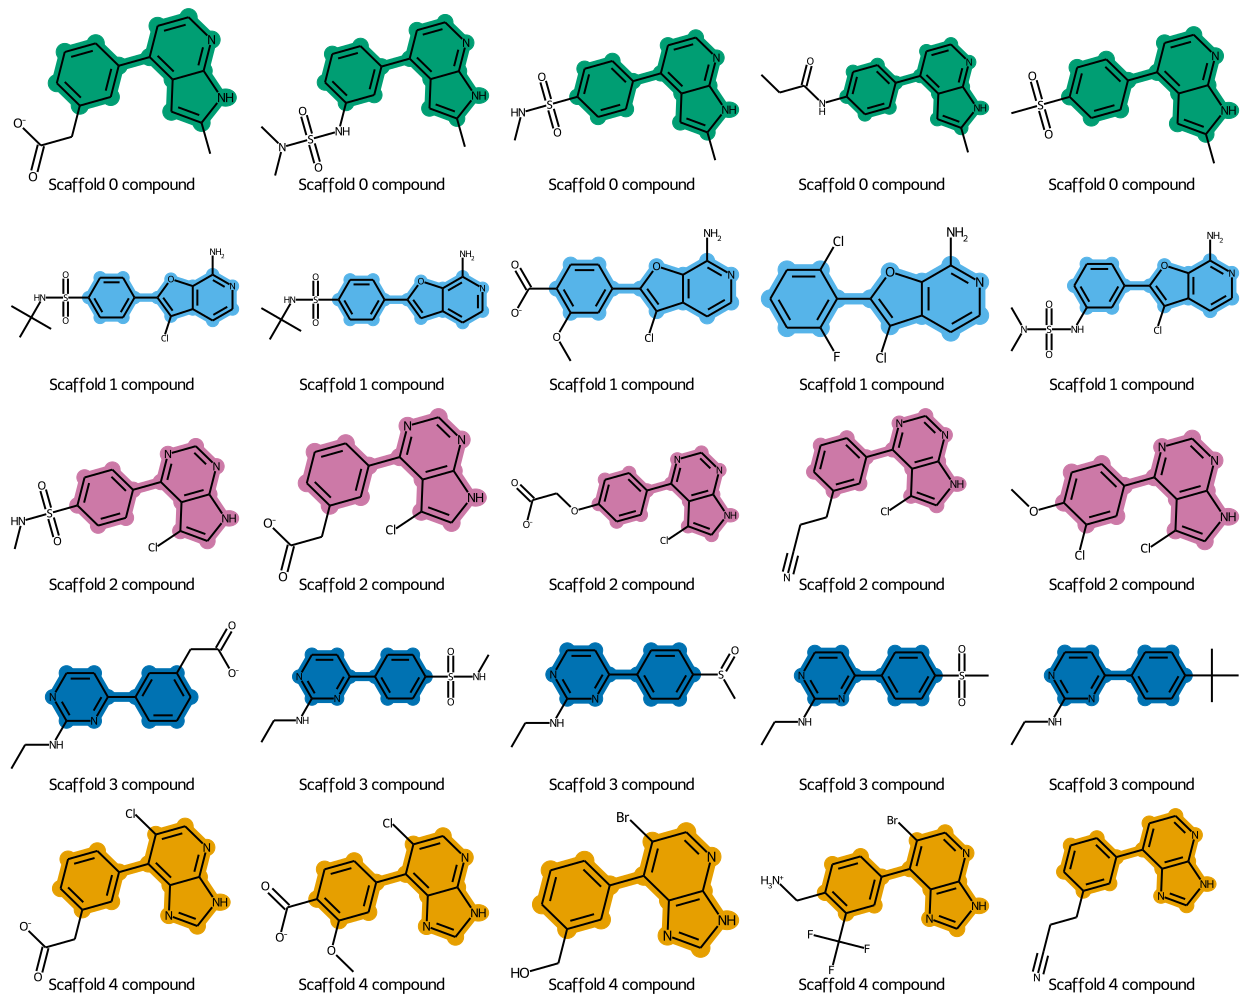

In [12]:
display.Image(draw_colored_scaffold_ligands(data))

In the following, we will look at the estimated binding affinity of the ligands with the most frequent scaffolds

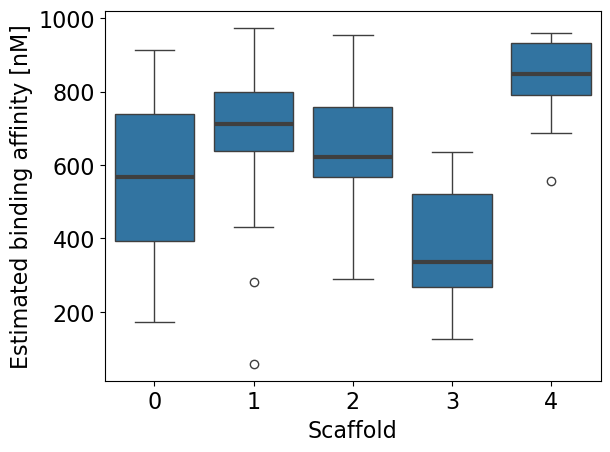

In [13]:
# plot binding affinity of top 5
sns.boxplot(
    x = 'scaffold_id',
    y='binding_affinity',
    data=data[data['scaffold_id'] < 5],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Estimated binding affinity [nM]', fontsize=16)
plt.xlabel('Scaffold', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Now, we will inspect the frequency of distinct AP fragments per scaffold.

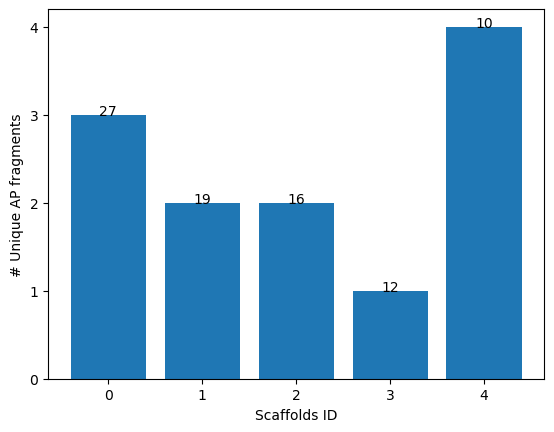

The numbers on top of the bars show the total number of compounds with the respective scaffold.


In [14]:
# unique AP fragments per scaffold
ap_frags_per_scaffold = [data[data['scaffold_id'] == i]['AP'].unique().size for i in range(5)]

plt.bar(range(5), ap_frags_per_scaffold)
plt.yticks(list(range(5)))
plt.xlabel("Scaffolds ID")
plt.ylabel("# Unique AP fragments")

# add the total number of compounds per scaffold on the top the bars
for i, n in enumerate(ap_frags_per_scaffold):
    plt.text(i, n, sum(data['scaffold_id'] == i), ha = 'center')
    
plt.show()
print(f"The numbers on top of the bars show the total number of compounds with the respective scaffold.")

Distinct AP fragments of the 5 most frequent scaffolds:

Legend: Fragment id | Scaffold


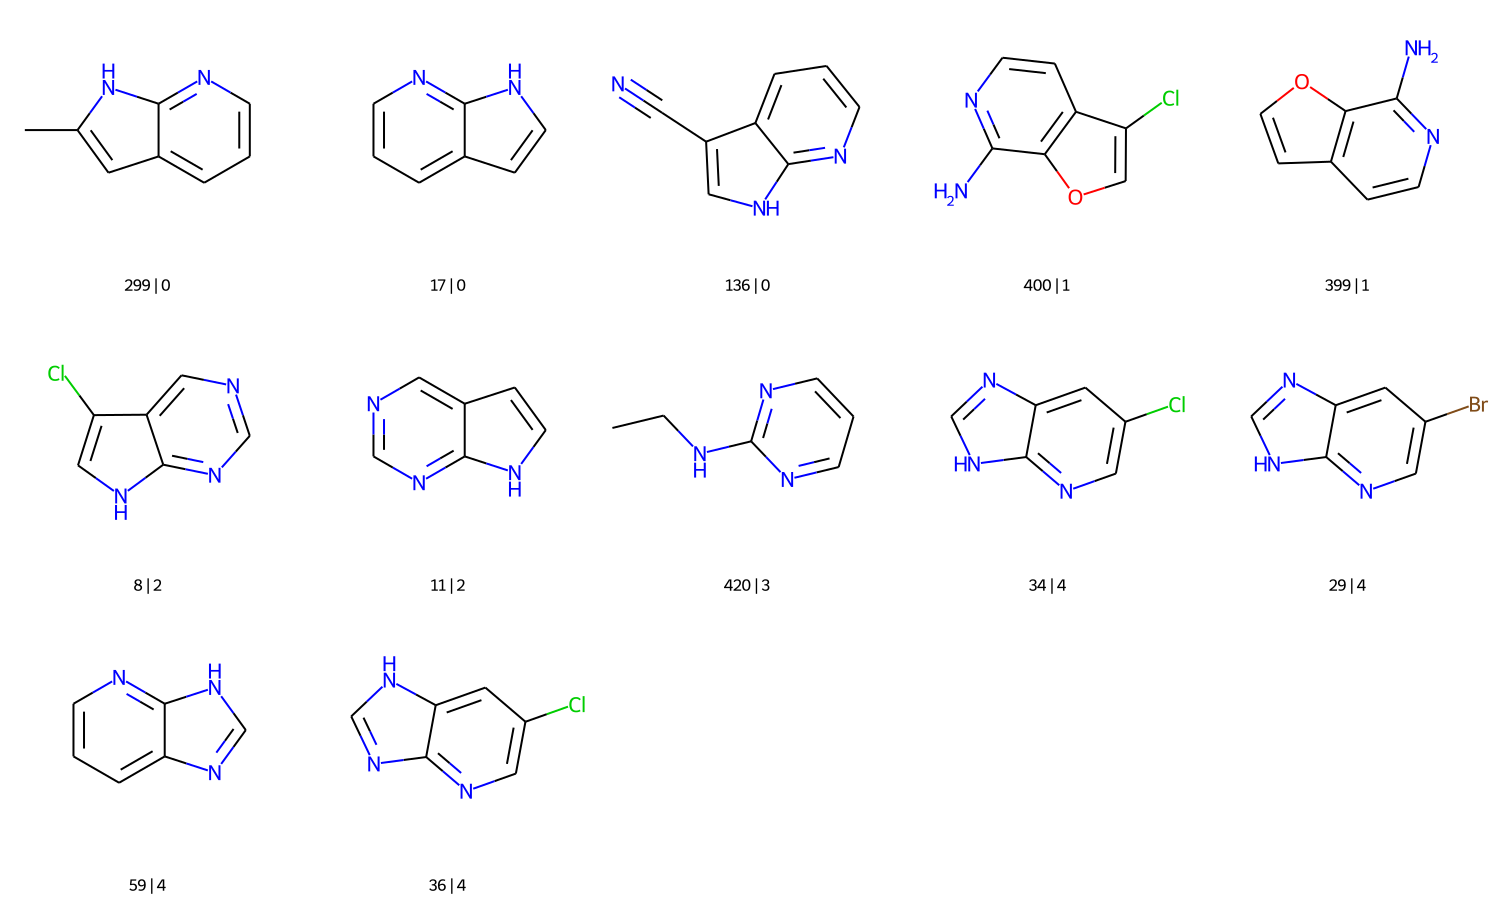

In [15]:
# get unique AP fragments of the 5 most frequent scaffolds
mols = []
legend = []
for i in range(5):
    scaffold_compounds = data[data['scaffold_id'] == i]
    mols += [AllChem.MolFromSmiles(mol) for mol in scaffold_compounds['AP_smiles'].unique()]
    legend += [f"{id} | {i}" for id in scaffold_compounds['AP'].unique()]

for mol in mols:
    AllChem.Compute2DCoords(mol)
    
print(f"Legend: Fragment id | Scaffold")
Draw.MolsToGridImage(
    mols, 
    legends=legend,  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(300, 300)
)

### 1.3 Shannon entropy
To *measure* the entropy of the $n$ distinct scaffolds, we calculate the Shannon Entropy 

$SE = \sum_{i=1}^np_ilog_2(p_i)$,

where $p_i$ is the frequency of scaffold $i$ in the set of generated ligands. The scaled SE

$SSE = \frac{SE}{log_2(n)}$

scales the $SE$ to a value between $0$ and $1$. A SSE near $1$ indicates a high entropy, while a value equal $0$ means, that all compounds have the same scaffold.

In [16]:
# Shannon entropy
P = data.index.size
se = - sum((scaffold / P) * math.log2(scaffold / P) for scaffold in scaffolds)
sse = se / math.log2(scaffolds.size)
print(f"SE: {se}\nSSE: {sse}")

SE: 9.295415964180085
SSE: 0.9638692014130108


## 2. Tanimoto similarity
To analyse the fingerprint-based diversity of the dataset, we determine the RDKit (topological) fingerprints of all compounds and calculate the Tanimoto coefficient of all pairs of compound fingerprints.

In [17]:
# generate and add rdkit fingerprint to dataframe
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
data['rdkit_fingerprint'] = [rdkit_gen.GetFingerprint(MolFromInchi(ligand_inchi)) for ligand_inchi in data.inchi]

In [18]:
data['mean_tanimoto_sims'] = data['rdkit_fingerprint'].apply(lambda fp: mean_tanimoto_similarity(data['rdkit_fingerprint'], fp))
data['nearest_neighbor_sim'] = data['rdkit_fingerprint'].apply(lambda fp: max_tanimoto_similarity(data['rdkit_fingerprint'], fp))

Inspecting the mean tanimoto similarity between each ligand to the respective remaining ligands.

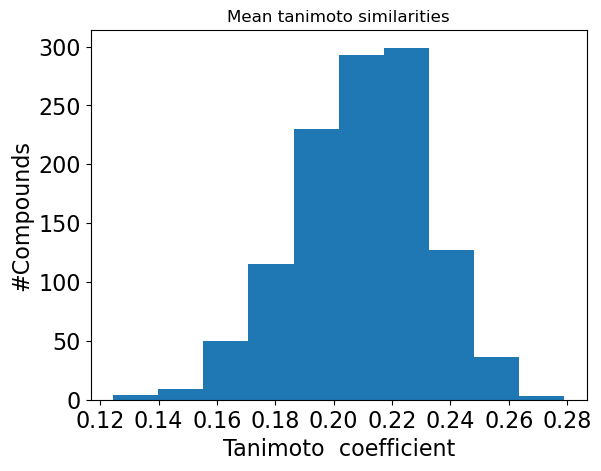

In [19]:
plt.title("Mean tanimoto similarities")
plt.hist(data['mean_tanimoto_sims'])
plt.xlabel('Tanimoto  coefficient', fontsize=16)
plt.ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [20]:
print(f"Tanimoto mean similarity statistics:\n{data['mean_tanimoto_sims'].describe()}")

Tanimoto mean similarity statistics:
count    1166.000000
mean        0.209408
std         0.022376
min         0.124457
25%         0.195144
50%         0.211493
75%         0.224630
max         0.278992
Name: mean_tanimoto_sims, dtype: float64


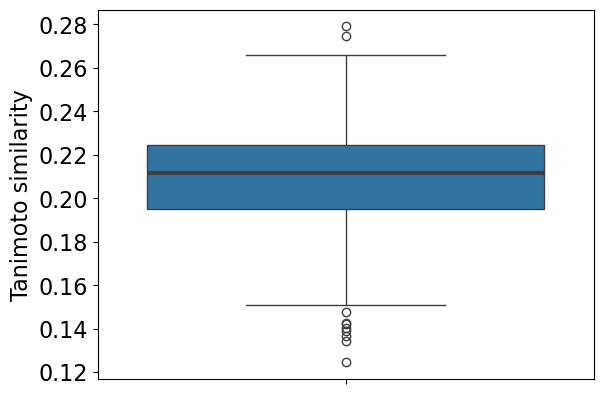

In [21]:
sns.boxplot(
    data['mean_tanimoto_sims'],
    medianprops={"linewidth": 3, "linestyle": "-"},
    )
plt.ylabel('Tanimoto similarity', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In the following, we consider that similiarities between a ligand and its respective most similiar ligand in the dataset.

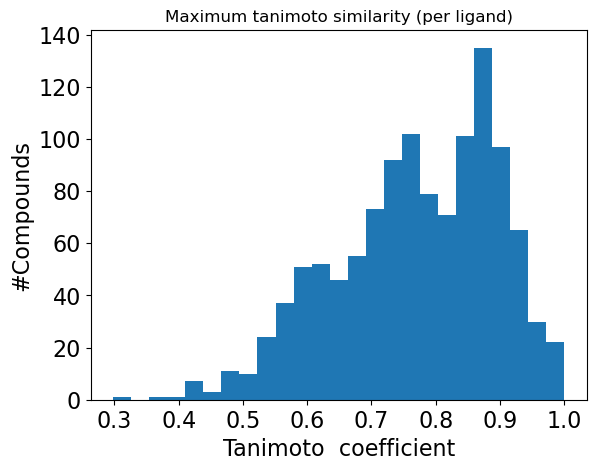

In [22]:
plt.hist(data['nearest_neighbor_sim'], bins=25)
plt.title("Maximum tanimoto similarity (per ligand)")
plt.xlabel('Tanimoto  coefficient', fontsize=16)
plt.ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [29]:
print(f"#Compounds with NN tanimoto coeffiecient: ")
print(f">=0.9:\t{sum(data['nearest_neighbor_sim'] >= 0.9)} ({100 * sum(data['nearest_neighbor_sim'] >= 0.9)/len(data):.1f}%)")
print(f">=0.8:\t{sum(data['nearest_neighbor_sim'] >= 0.8)} ({100 * sum(data['nearest_neighbor_sim'] >= 0.8)/len(data):.1f}%)")
print(f"<0.8:\t{sum(data['nearest_neighbor_sim'] < 0.8)} ({100 * sum(data['nearest_neighbor_sim'] < 0.8)/len(data):.1f}%)")

#Compounds with NN tanimoto coeffiecient: 
>=0.9:	177 (15.2%)
>=0.8:	534 (45.8%)
<0.8:	632 (54.2%)


Heatmap of Tanimoto similairties:

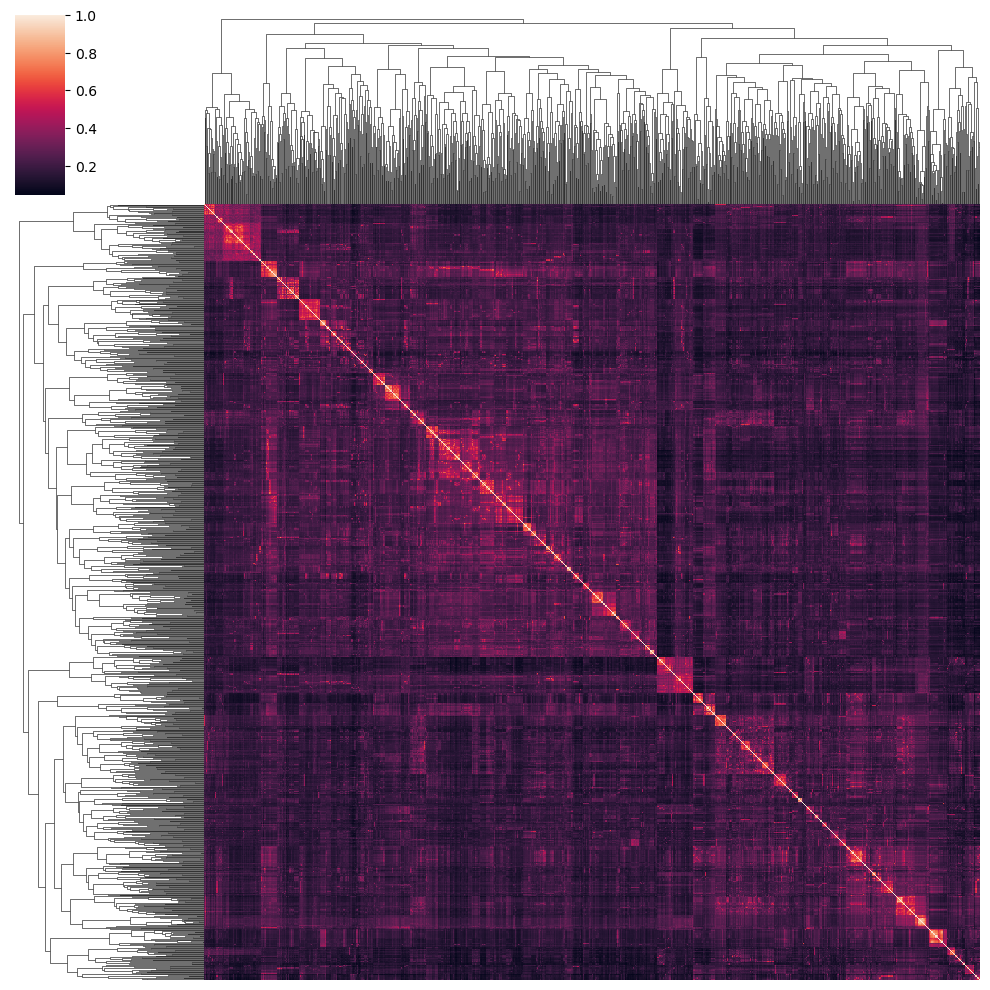

In [23]:
g = sns.clustermap(tanimoto_similarity_matrix(data['rdkit_fingerprint']), yticklabels=False, xticklabels=False)